## Setting Up:

In [29]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import zipfile
import cdsapi
import zipfile
import numpy as np
import glob
import xarray as xr
import matplotlib.pyplot as plt

from scripts.config_NOR import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
!pip show cdsapi

Name: cdsapi
Version: 0.7.5
Summary: Climate Data Store API
Home-page: https://github.com/ecmwf/cdsapi
Author: ECMWF
Author-email: software.support@ecmwf.int
License: Apache 2.0
Location: /home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages
Requires: datapi, requests, tqdm
Required-by: massbalancemachine


In [ ]:
RUN = True
if RUN:
    dataset = "reanalysis-era5-land-monthly-means"
    request = {
        "product_type": ["monthly_averaged_reanalysis"],
        "variable": ['10m_u_component_of_wind',
                '10m_v_component_of_wind',
                '2m_temperature',
                'forecast_albedo',
                'snow_cover',
                'snow_density',
                'snow_depth_water_equivalent',
                'snowfall',
                'snowmelt',
                'surface_latent_heat_flux',
                'surface_net_thermal_radiation',
                'surface_sensible_heat_flux',
                'surface_solar_radiation_downwards',
                'total_precipitation'],
        "year": [
            "1950", "1951", "1952",
            "1953", "1954", "1955",
            "1956", "1957", "1958",
            "1959", "1960", "1961",
            "1962", "1963", "1964",
            "1965", "1966", "1967",
            "1968", "1969", "1970",
            "1971", "1972", "1973",
            "1974", "1975", "1976",
            "1977", "1978", "1979",
            "1980", "1981", "1982",
            "1983", "1984", "1985",
            "1986", "1987", "1988",
            "1989", "1990", "1991",
            "1992", "1993", "1994",
            "1995", "1996", "1997",
            "1998", "1999", "2000",
            "2001", "2002", "2003",
            "2004", "2005", "2006",
            "2007", "2008", "2009",
            "2010", "2011", "2012",
            "2013", "2014", "2015",
            "2016", "2017", "2018",
            "2019", "2020", "2021",
            "2022", "2023", "2024"
        ],
        "month": [
            "01", "02", "03",
            "04", "05", "06",
            "07", "08", "09",
            "10", "11", "12"
        ],
        "time": ["00:00"],
        "data_format": "netcdf",
        "download_format": "zip",
        'area': [
                72,    # North latitude
                30,     # West longitude
                70,    # South latitude
                32,    # East longitude
            ]
    }

    client = cdsapi.Client()
    client.retrieve(dataset, request).download(path_ERA5_raw +'download.netcdf.zip')

with zipfile.ZipFile(path_ERA5_raw +'download.netcdf.zip', 'r') as zip_ref:
    zip_ref.extractall(path_ERA5_raw)

2025-05-07 09:57:57,160 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-07 09:57:57,161 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-05-07 09:57:58,217 INFO Request ID is 13fea3a7-bee4-401a-8081-2dcbba5d347f
2025-05-07 09:57:58,274 INFO status has been updated to accepted
2025-05-07 09:58:48,894 INFO status has been updated to running
2025-05-07 11:04:29,407 INFO status has been updated to successful


6a043635e0a92f8f9a602d7de5dc6534.zip:   0%|          | 0.00/2.15M [00:00<?, ?B/s]

In [8]:
dataset = "reanalysis-era5-single-levels"
request = {
    "product_type": ["reanalysis"],
    "variable": ["geopotential"],
    "year": ["2024"],
    "month": ["06"],
    "day": ["01"],
    "time": ["12:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [
            72,    # North latitude
            30,     # West longitude
            70,    # South latitude
            32,    # East longitude
            ]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(path_ERA5_raw+'era5_geopotential_pressure.nc')

2025-05-07 11:04:30,117 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-07 11:04:30,118 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-05-07 11:04:30,462 INFO Request ID is e9da53c7-b402-44d6-97ab-d87455addae5
2025-05-07 11:04:30,505 INFO status has been updated to accepted
2025-05-07 11:04:44,245 INFO status has been updated to running
2025-05-07 11:04:51,935 INFO status has been updated to successful


448363aa3758fee7c7c6ef00f455870c.nc:   0%|          | 0.00/25.0k [00:00<?, ?B/s]

'/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/ERA5Land/raw/era5_geopotential_pressure.nc'

## Download monthly ERA5-Land variables:

In [ ]:
"""
RUN = True
if RUN:
    os.makedirs(path_ERA5_raw, exist_ok=True)
    c = cdsapi.Client()
    c.retrieve(
        'reanalysis-era5-land-monthly-means', {
            'product_type': ['monthly_averaged_reanalysis'],
            'variable': [
                '10m_u_component_of_wind',
                '10m_v_component_of_wind',
                '2m_temperature',
                'forecast_albedo',
                'snow_cover',
                'snow_density',
                'snow_depth_water_equivalent',
                'snowfall',
                'snowmelt',
                'surface_latent_heat_flux',
                'surface_net_thermal_radiation',
                'surface_sensible_heat_flux',
                'surface_solar_radiation_downwards',
                'total_precipitation',
            ],
            'year': [
                '2011',
                '2012',
                '2013',
                '2014',
                '2015',
                '2016',
                '2017',
                '2018',
                '2019',
                '2020',
                '2021',
                '2022',
                '2023',
                '2024',
            ],
            'month': [
                '01',
                '02',
                '03',
                '04',
                '05',
                '06',
                '07',
                '08',
                '09',
                '10',
                '11',
                '12',
            ],
            'time': ['00:00'],
            "data_format": "netcdf",
            "download_format": "zip",
            'area': [
                72,    # North latitude
                30,     # West longitude 
                70,    # South latitude
                32,    # East longitude
            ]
        }, path_ERA5_raw+'download.netcdf.zip')
    with zipfile.ZipFile(path_ERA5_raw+'download.netcdf.zip', 'r') as zip:
        zip.extractall(path_ERA5_raw)
    c.retrieve("reanalysis-era5-single-levels", {
            "product_type": ["reanalysis"],
            "variable": ["geopotential"],
            "year": ["2024"],
            "month": ["06"],
            "day": ["01"],
            "time": ["12:00"],
            "data_format": "netcdf",
            'area': [
                72,    # North latitude
                30,     # West longitude
                70,    # South latitude
                32,    # East longitude
            ]
        }, path_ERA5_raw+'era5_geopotential_pressure.nc')

"""

In [47]:
! ls '/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/ERA5Land/raw'

if os.path.exists(path_ERA5_raw + "era5_monthly_averaged_data.nc"):
    print(f"Removing old file: {path_ERA5_raw + 'era5_monthly_averaged_data.nc'}")
    os.remove(path_ERA5_raw + "era5_monthly_averaged_data.nc")
else:
    print("No previous file found to delete.")

! ls '/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/ERA5Land/raw'

data_stream-moda.nc  download.netcdf.zip  era5_geopotential_pressure.nc
No previous file found to delete.
data_stream-moda.nc  download.netcdf.zip  era5_geopotential_pressure.nc


In [41]:
xr.open_dataset(path_ERA5_raw+'data_stream-moda.nc')

<xarray.Dataset> Size: 22MB
Dimensions:     (valid_time: 904, latitude: 21, longitude: 21)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 7kB 1950-01-01 ... 2025-04-01
  * latitude    (latitude) float64 168B 72.0 71.9 71.8 71.7 ... 70.2 70.1 70.0
  * longitude   (longitude) float64 168B 30.0 30.1 30.2 30.3 ... 31.8 31.9 32.0
    expver      (valid_time) <U4 14kB ...
Data variables: (12/14)
    u10         (valid_time, latitude, longitude) float32 2MB ...
    v10         (valid_time, latitude, longitude) float32 2MB ...
    t2m         (valid_time, latitude, longitude) float32 2MB ...
    fal         (valid_time, latitude, longitude) float32 2MB ...
    snowc       (valid_time, latitude, longitude) float32 2MB ...
    rsn         (valid_time, latitude, longitude) float32 2MB ...
    ...          ...
    smlt        (valid_time, latitude, longitude) float32 2MB ...
    slhf        (valid_time, latitude, longitude) float32 2MB ...
    str         (valid_time, latitude, longitude) float32 2MB ...
    sshf        (valid_time, latitude, longitude) float32 2MB ...
    ssrd        (valid_time, latitude, longitude) float32 2MB ...
    tp          (valid_time, latitude, longitude) float32 2MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-07T11:02 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
delete_flag == True

# Delete the old file if it exists
if os.path.exists(path_ERA5_raw + "era5_monthly_averaged_data.nc") and delete_flag == True:
    print(f"Removing old file: {path_ERA5_raw + 'era5_monthly_averaged_data.nc'}")
    os.remove(path_ERA5_raw + "era5_monthly_averaged_data.nc")
else:
    print("No previous file found to delete.")

# Load datasets
print("Loading datasets...")
monthly_ds = xr.open_dataset(path_ERA5_raw + 'data_stream-moda.nc')
geopotential_ds = xr.open_dataset(path_ERA5_raw + 'era5_geopotential_pressure.nc')

# Print basic info
print(f"Monthly dataset: {list(monthly_ds.data_vars)}")
print(f"Geopotential dataset: {list(geopotential_ds.data_vars)}")

# Rename the geopotential coordinate for compatibility
if 'time' in geopotential_ds.coords and 'time' in monthly_ds.coords:
    # Make sure they use the same coordinate name
    geopotential_ds = geopotential_ds.rename({'time': 'time'})

# Simple merge - this should handle the coordinate alignment
print("Merging datasets...")
merged = xr.merge([monthly_ds, geopotential_ds], compat='override')

# Save the result
print("Saving merged dataset...")
merged.to_netcdf(path_ERA5_raw + "era5_monthly_averaged_data.nc")

# Check the result
ds = xr.open_dataset(path_ERA5_raw + "era5_monthly_averaged_data.nc")
print("\nVerification:")
print(f"Variables: {list(ds.data_vars)}")
print(f"Dimensions: {dict(ds.dims)}")

# Quick check for zeros
for var in list(ds.data_vars)[:5]:  # Check first 5 variables
    print(f"{var}: min={float(ds[var].min().values)}, max={float(ds[var].max().values)}")

No previous file found to delete.
Loading datasets...
Monthly dataset: ['u10', 'v10', 't2m', 'fal', 'snowc', 'rsn', 'sd', 'sf', 'smlt', 'slhf', 'str', 'sshf', 'ssrd', 'tp']
Geopotential dataset: ['z']
Merging datasets...
Saving merged dataset...

Verification:
Variables: ['u10', 'v10', 't2m', 'fal', 'snowc', 'rsn', 'sd', 'sf', 'smlt', 'slhf', 'str', 'sshf', 'ssrd', 'tp', 'z']
Dimensions: {'valid_time': 905, 'latitude': 28, 'longitude': 28}
u10: min=-3.105898857116699, max=5.490514755249023
v10: min=-3.7218008041381836, max=8.122011184692383
t2m: min=254.61170959472656, max=290.4276123046875
fal: min=0.06599295139312744, max=0.8559753894805908
snowc: min=0.0, max=100.0


In [54]:
ds = xr.open_dataset(path_ERA5_raw+'era5_monthly_averaged_data.nc')

print("======== ERA5LAND DATASET STATS ========")

# Basic info
print(f"\nDimensions: {dict(ds.dims)}")
print(f"Variables: {list(ds.data_vars)}")

# Time range
if 'valid_time' in ds.coords:
    print(f"\nTime range: {ds.valid_time.values.min()} to {ds.valid_time.values.max()}")
    print(f"Number of timesteps: {len(ds.valid_time)}")

# Spatial coverage
print(f"Spatial domain: lon {ds.longitude.values.min():.2f}° to {ds.longitude.values.max():.2f}°, " 
      f"lat {ds.latitude.values.min():.2f}° to {ds.latitude.values.max():.2f}°")
print(f"Grid size: {len(ds.longitude)}×{len(ds.latitude)} points")

# Key variable stats table
print("\n--- VARIABLE STATISTICS ---")
print(f"{'Variable':<25} {'Min':>12} {'Max':>12} {'Mean':>12} {'NaNs':>8} {'Units':<10}")
print("-" * 75)

for var_name in sorted(ds.data_vars):
    var = ds[var_name]
    
    # Get stats
    min_val = float(var.min().values)
    max_val = float(var.max().values)
    mean_val = float(var.mean().values)
    nan_count = np.isnan(var).sum().values
    units = getattr(var, 'units', '')
    
    # Special handling for temperature (convert to °C)
    if var_name == '2m_temperature' and units == 'K':
        min_val -= 273.15
        max_val -= 273.15
        mean_val -= 273.15
        units = '°C'
    
    # Print stats in table format
    print(f"{var_name:<25} {min_val:>12.4f} {max_val:>12.4f} {mean_val:>12.4f} {nan_count:>8} {units:<10}")

# Check for any issues
issue_count = 0

# 1. Check for NaNs
for var_name in ds.data_vars:
    nan_count = np.isnan(ds[var_name]).sum().values
    if nan_count > 0:
        issue_count += 1
        print(f"⚠️ {var_name} has {nan_count} NaN values")

# 2. Check for suspicious temperature values
if '2m_temperature' in ds:
    temp = ds['2m_temperature']
    temp_min = float(temp.min().values)
    temp_max = float(temp.max().values)
    
    if hasattr(temp, 'units') and temp.units == 'K':
        temp_min -= 273.15
        temp_max -= 273.15
    
    if temp_min < -60 or temp_max > 40:
        issue_count += 1
        print(f"⚠️ Suspicious temperature range: {temp_min:.1f}°C to {temp_max:.1f}°C")

# 3. Check for negative precipitation
if 'total_precipitation' in ds and (ds['total_precipitation'] < 0).any().values:
    issue_count += 1
    print("⚠️ Negative precipitation values found")

# 4. Check for extreme precipitation
if 'total_precipitation' in ds:
    precip_max = float(ds['total_precipitation'].max().values)
    if precip_max > 1000:
        issue_count += 1
        print(f"⚠️ Extreme precipitation max value: {precip_max}")

if issue_count == 0:
    print("\n✅ No obvious issues detected in the dataset")
else:
    print(f"\n⚠️ {issue_count} potential issues found")

======== ERA5LAND DATASET STATS ========

Dimensions: {'valid_time': 905, 'latitude': 28, 'longitude': 28}
Variables: ['u10', 'v10', 't2m', 'fal', 'snowc', 'rsn', 'sd', 'sf', 'smlt', 'slhf', 'str', 'sshf', 'ssrd', 'tp', 'z']

Time range: 1950-01-01T00:00:00.000000000 to 2025-04-01T00:00:00.000000000
Number of timesteps: 905
Spatial domain: lon 30.00° to 32.00°, lat 70.00° to 72.00°
Grid size: 28×28 points

--- VARIABLE STATISTICS ---
Variable                           Min          Max         Mean     NaNs Units     
---------------------------------------------------------------------------
fal                             0.0660       0.8560       0.4410   672456 (0 - 1)   
rsn                           100.0000     437.5857     204.6343   672456 kg m**-3  
sd                             -0.0000       0.4930       0.0828   672456 m of water equivalent
sf                              0.0000       0.0058       0.0009   672456 m of water equivalent
slhf                      -6713308.0000

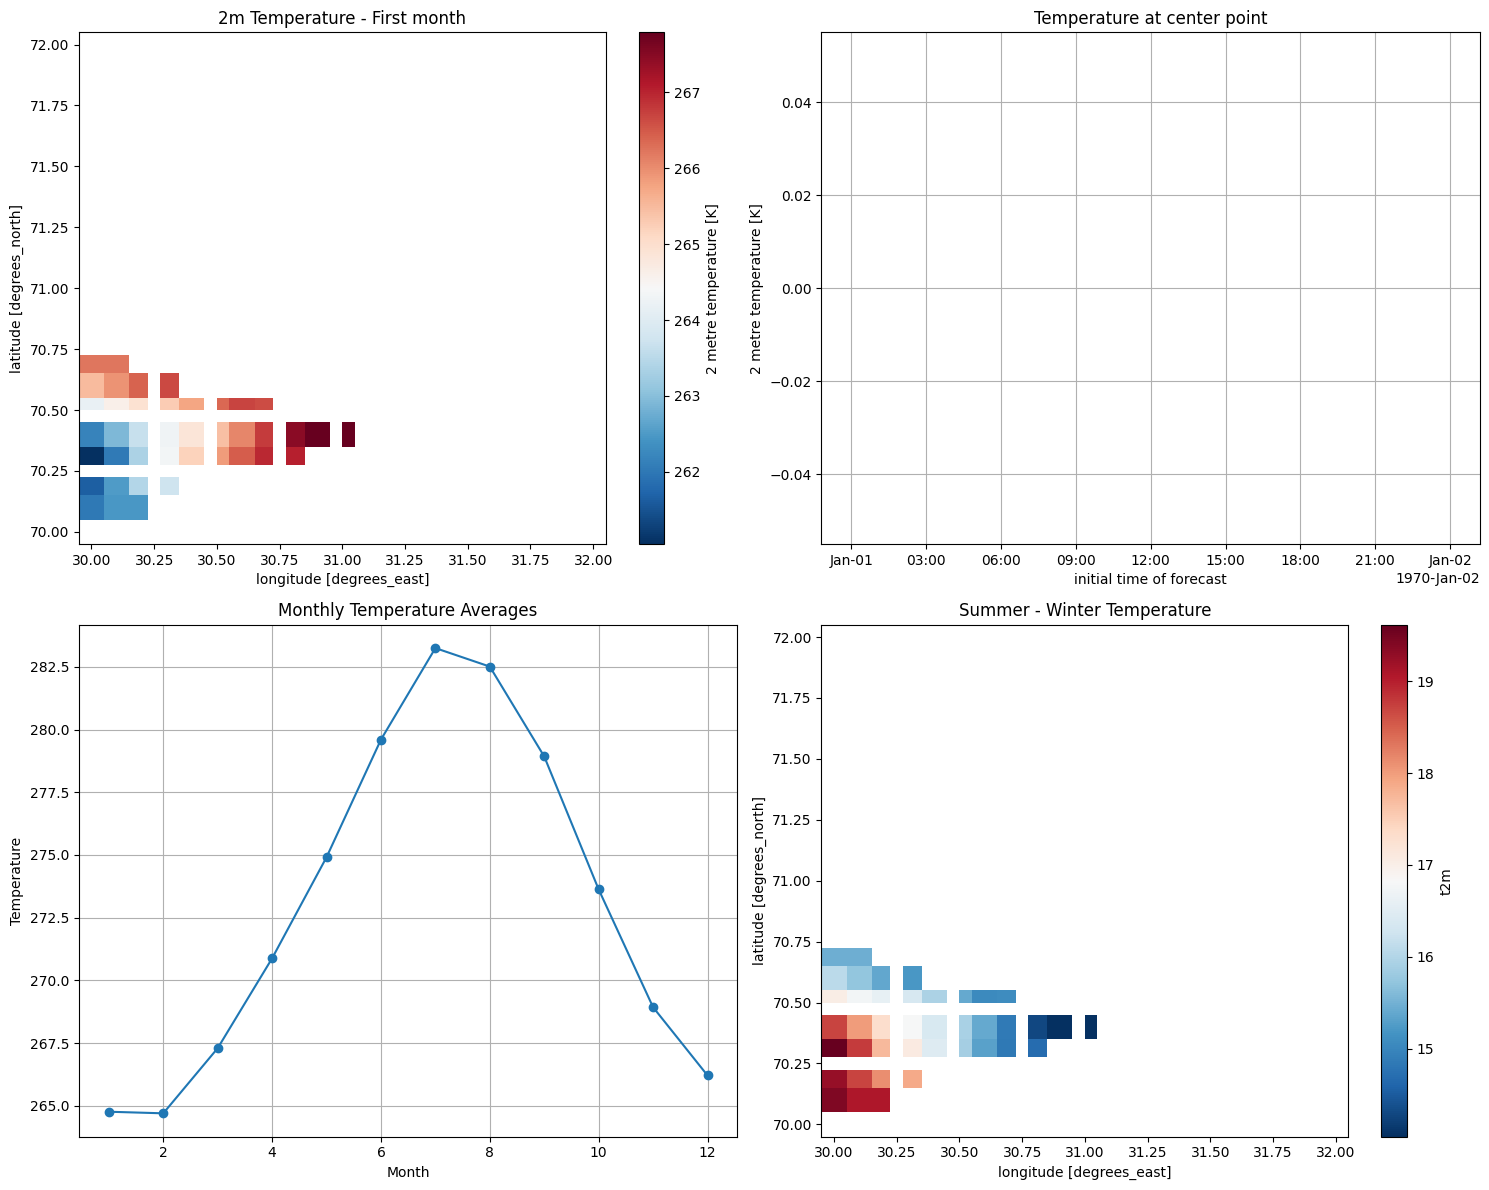

Variable: t2m
Min value: 254.61170959472656
Max value: 290.4276123046875
Mean value: 272.9390563964844


In [61]:
# Load the dataset
ds = xr.open_dataset(path_ERA5_raw + "era5_monthly_averaged_data.nc")

# Create a figure with multiple plots to verify the temperature data
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# 1. First plot - temperature map for first timestep
if 't2m' in ds:
    var_name = 't2m'
elif '2m_temperature' in ds:
    var_name = '2m_temperature'
else:
    print("Temperature variable not found")
    var_name = None

if var_name:
    # First time step temperature map
    ds[var_name].isel(valid_time=0).plot(ax=axs[0,0], cmap='RdBu_r')
    axs[0,0].set_title(f'2m Temperature - First month')
    
    # Time series at center point
    center_lat_idx = len(ds.latitude) // 2
    center_lon_idx = len(ds.longitude) // 2
    ds[var_name].isel(latitude=center_lat_idx, longitude=center_lon_idx).plot(ax=axs[0,1])
    axs[0,1].set_title(f'Temperature at center point')
    axs[0,1].grid(True)
    
    # Average annual cycle
    if 'valid_time' in ds.dims:
        times = pd.to_datetime(ds.valid_time.values)
        # Add month as coordinate
        months = [t.month for t in times]
        # Create month groups
        month_groups = {}
        for m in range(1, 13):
            month_groups[m] = []
        
        for i, m in enumerate(months):
            month_groups[m].append(i)
        
        # Calculate and plot monthly means
        monthly_means = []
        for m in range(1, 13):
            if month_groups[m]:
                monthly_means.append(ds[var_name].isel(valid_time=month_groups[m]).mean().values)
            else:
                monthly_means.append(np.nan)
                
        axs[1,0].plot(range(1, 13), monthly_means, 'o-')
        axs[1,0].set_title('Monthly Temperature Averages')
        axs[1,0].set_xlabel('Month')
        axs[1,0].set_ylabel('Temperature')
        axs[1,0].grid(True)
    
    # Season difference
    summer_months = [6, 7, 8]
    winter_months = [12, 1, 2]
    
    summer_indices = []
    winter_indices = []
    
    for i, t in enumerate(times):
        if t.month in summer_months:
            summer_indices.append(i)
        if t.month in winter_months:
            winter_indices.append(i)
    
    summer_temp = ds[var_name].isel(valid_time=summer_indices).mean(dim='valid_time')
    winter_temp = ds[var_name].isel(valid_time=winter_indices).mean(dim='valid_time')
    temp_diff = summer_temp - winter_temp
    
    temp_diff.plot(ax=axs[1,1], cmap='RdBu_r')
    axs[1,1].set_title('Summer - Winter Temperature')

plt.tight_layout()
plt.show()

# Print basic statistics
print(f"Variable: {var_name}")
print(f"Min value: {float(ds[var_name].min().values)}")
print(f"Max value: {float(ds[var_name].max().values)}")
print(f"Mean value: {float(ds[var_name].mean().values)}")